# Image segmentation

In this notebook we try a different type of computer vision task, which is to take in images and draw a line around objects of interest, so that they are very precicely located. Finding different objects in an image is typically just called object detection, but when we also highlight the detailed shape, it's known as _image segmentation_.

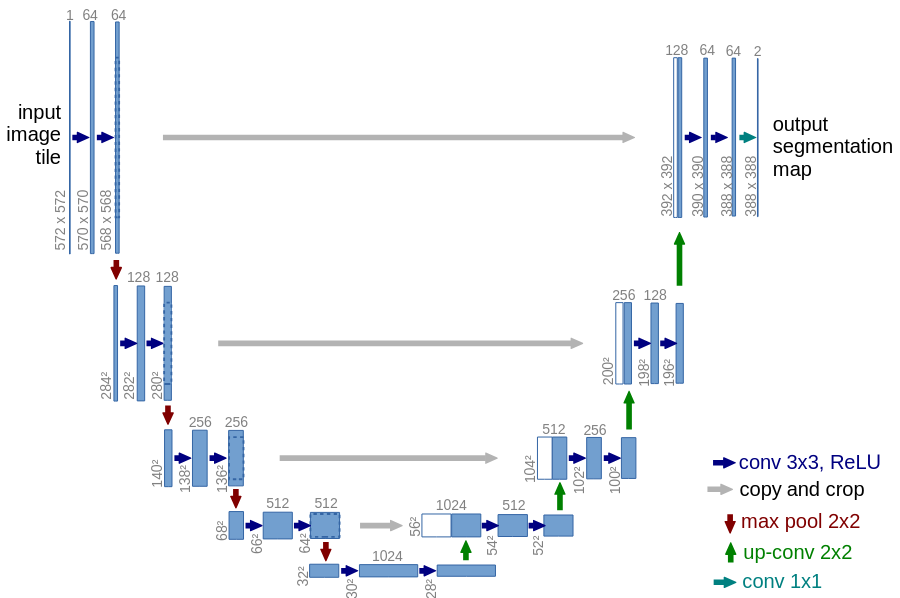

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import os

## Download the data

We use the [_Oxford Pets_](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset, which contains annotated images of... pets. This is a is a 773MB download.

In case you want to try out image segmentation at a bigger scale, the best-known dataset is called [COCO](https://cocodataset.org/#home) and contains some 330K images.

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
!ls

Make lists of the input files.

In [ ]:

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


In the `annotations` directory we find the segmentation masks. The mask defines the area in the image where the object is.

Plot an example to see what they look like:

In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image
display(Image(filename=input_img_paths[0]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)


So this is the thing we want to make our model predict.

These data are a little more demanding than usual when it comes to data loading, and we need some custom code to prepare them as a `tf.data.Dataset`.

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


Now create the datasets

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)


## Create the model

Our task is to make a (smaller) version of the U-Net shown above. Since we have smaller resolution images than the original U-Net, we need fewer blocks to get down to the smallest resolution, before going back up.

### <span style="color: red; font-weight: bold;">Exercise:<span>

Fill in the missing pieces below to build the U-Net model.

In [ ]:
def encoder_block(inputs, filters, stride):
    """
    A block that applies 2 times convolutional layers with batch normalisation,
    then returns 1) the output, and 2) the downsampled output, after max pooling.
    """

    # TODO:
    # Add convolutional layers, batch norm, and activations.

    x = ...

    # Pooling layer
    pool = keras.layers.MaxPooling2D(pool_size=2)(x)

    return x, pool


def decoder_block(inputs, inputs_skip, filters, stride):
    """
    A block that receives two inputs -- one from the previous convolutional
    block "below", and one from the skip connection. The shapes of these
    don't match, so we upsample the input from the previous convolution.
    Then the two inputs are merged, and we do 2x convolutions on that.

    The upsampling does "the opposite" of the Conv2D layers, and is achieved
    with the Conv2DTranspose layer.
    """

    # Upsample the inputs
    x = keras.layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(inputs)

    # In case you need to do some debugging
    # print('In decoder block: x.shape:', x.shape, 'inputs_skip.shape:', inputs_skip.shape)

    # Concatenate with the skip connection
    x = keras.layers.Concatenate()([x, inputs_skip])

    # TODO:
    # Apply 2x convolutions
    x = ...


    return x


def create_unet(image_shape):

    inputs = keras.layers.Input(image_shape)

    # Build the encoder, which is the left part of the U shape in the network
    # architecture. Here we need to keep track of the "skip" connections.
    conv1, pool1 = encoder_block(inputs, 64, 1)
    conv2, pool2 = encoder_block(pool1, 64, 1)
    conv3, pool3 = encoder_block(pool2, 64, 1)

    # The lowermost convolutions -- has no pooling layer at the end.
    x = keras.layers.Conv2D(128, 3, padding="same")(pool3)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Conv2D(128, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    # Build the decoder, which is the right-hand part if the U-Net, where we
    # increase the resolution again (while adding in the skip connections).
    x = decoder_block(x, conv3, 64, 1)
    x = decoder_block(x, conv2, 64, 1)
    x = decoder_block(x, conv1, 64, 1)

    # The output -- a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Finalise the model
    model = keras.Model(inputs, outputs)

    return model

Plot the model to see if it looks as expected:


In [ ]:
model = create_unet(img_size + (3,))    # image shape plus RGB channels

keras.utils.plot_model(model, dpi=75, show_shapes=True)

If yes, then we are ready to train it!

In [ ]:
# We use the "sparse" version of categorical_crossentropy because the target
# data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

# TODO:
# If needed, implement measures to improve the training (e.g. learning rate
# scheduling)

# Train the model, doing validation at the end of each epoch.
epochs = 25
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Plot some predictions:

(remember we are working on 160x160 pixel versions, so the images are smaller than original):

In [ ]:
for images, targets in valid_dataset.take(1):

    preds = model.predict(images, verbose=0)

    for i in range(3):

        display(keras.utils.array_to_img(images[i]))

        mask = np.argmax(preds[i], axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
        display(img)
